In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

In [2]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/data/gtex_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/analysis_21042020/"
fig_dir = "/ccb/salz8-1/avaraby/tx_noise/analysis_21042020/figs/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

readlen = 101
num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
# first load all annotations into containers for processing later
real_gtfs = [list() for x in range(num_tissues)]
splicing_gtfs = [list() for x in range(num_tissues)]
intronic_gtfs = [list() for x in range(num_tissues)]
intergenic_gtfs = [list() for x in range(num_tissues)]

for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        real_gtfs[tissue_num].append(pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        splicing_gtfs[tissue_num].append(pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        intronic_gtfs[tissue_num].append(pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        intergenic_gtfs[tissue_num].append(pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        
        real_gtfs[tissue_num][-1] = real_gtfs[tissue_num][-1][real_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        splicing_gtfs[tissue_num][-1] = splicing_gtfs[tissue_num][-1][splicing_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        intronic_gtfs[tissue_num][-1] = intronic_gtfs[tissue_num][-1][intronic_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        intergenic_gtfs[tissue_num][-1] = intergenic_gtfs[tissue_num][-1][intergenic_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        
        real_gtfs[tissue_num][-1]["lid"] = real_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing_gtfs[tissue_num][-1]["lid"] = splicing_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic_gtfs[tissue_num][-1]["lid"] = intronic_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic_gtfs[tissue_num][-1]["lid"] = intergenic_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        
        real_gtfs[tissue_num][-1]["tid"] = real_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing_gtfs[tissue_num][-1]["tid"] = splicing_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic_gtfs[tissue_num][-1]["tid"] = intronic_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic_gtfs[tissue_num][-1]["tid"] = intergenic_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        
        real_tpm = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",names=["tpm"])
        real_gtfs[tissue_num][-1] = pd.concat([real_gtfs[tissue_num][-1],real_tpm],axis=1)
        splicing_tpm = pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",names=["tpm"])
        splicing_gtfs[tissue_num][-1] = pd.concat([splicing_gtfs[tissue_num][-1],splicing_tpm],axis=1)
        intronic_tpm = pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",names=["tpm"])
        intronic_gtfs[tissue_num][-1] = pd.concat([intronic_gtfs[tissue_num][-1],intronic_tpm],axis=1)
        intergenic_tpm = pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",names=["tpm"])
        intergenic_gtfs[tissue_num][-1] = pd.concat([intergenic_gtfs[tissue_num][-1],intergenic_tpm],axis=1)

In [4]:
num_locs_tissue_real = list()
num_locs_tissue_intergenic = list()

num_locs_sample_real = list()
num_locs_sample_intergenic = list()

num_txs_sample_real = list()
num_txs_sample_splicing = list()
num_txs_sample_intronic = list()
num_txs_sample_intergenic = list()

for tissue_num in range(num_tissues):
    nltr = set() # num_locs_tissue_real
    nlti = set() # num_locs_tissue_intergenic
    for sample_num in range(num_samples):
        nlsr = set()
        nlsr = nlsr.union(set(real_gtfs[tissue_num][sample_num]["lid"]))
        nlsr = nlsr.union(set(splicing_gtfs[tissue_num][sample_num]["lid"]))
        nlsr = nlsr.union(set(intronic_gtfs[tissue_num][sample_num]["lid"]))
        nlsi = set(intergenic_gtfs[tissue_num][sample_num]["lid"])
        
        nltr = nltr.union(nlsr)
        nlti = nlti.union(nlsi)
        
        num_locs_sample_real.append(len(nlsr))
        num_locs_sample_intergenic.append(len(nlsi))
        
        num_txs_sample_real.append(len(real_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_splicing.append(len(splicing_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_intronic.append(len(intronic_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_intergenic.append(len(intergenic_gtfs[tissue_num][sample_num]["tid"]))
        
    num_locs_tissue_real.append(len(nltr))
    num_locs_tissue_intergenic.append(len(nlti))

In [5]:
t_loc = pd.read_csv(base_dir_out+"res.num_locs_tissue")
# now we shall remove any outliers from the data
q25,q50,q75 = t_loc['real'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = t_loc[t_loc["real"]<=thw]["real"].max()
alw = t_loc[t_loc["real"]>=tlw]["real"].min()
t_loc = t_loc[(t_loc['real']<=ahw)&(t_loc['real']>=alw)]

q25,q50,q75 = t_loc['intergenic'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = t_loc[t_loc["intergenic"]<=thw]["intergenic"].max()
alw = t_loc[t_loc["intergenic"]>=tlw]["intergenic"].min()
t_loc = t_loc[(t_loc['intergenic']<=ahw)&(t_loc['intergenic']>=alw)]
t_loc.columns = ["Real","Intergenic"]
t_loc = pd.DataFrame(t_loc.stack()).reset_index().drop("level_0",axis=1)
t_loc.columns = ["Gene Type","Number of Genes"]
t_loc["Dataset"] = "GTEx"
num_locs_tissue_sim = pd.concat([pd.DataFrame(num_locs_tissue_real,columns=["Real"]),\
                                 pd.DataFrame(num_locs_tissue_intergenic,columns=["Intergenic"])],axis=1)
num_locs_tissue_sim = pd.DataFrame(num_locs_tissue_sim.stack()).reset_index().drop("level_0",axis=1)
num_locs_tissue_sim.columns = ["Gene Type","Number of Genes"]
num_locs_tissue_sim["Dataset"] = "Simulated"
res_tloc_df = pd.concat([t_loc,num_locs_tissue_sim],axis=0).reset_index(drop=True)
res_tloc_df

,Gene Type,Number of Genes,Dataset
0,Real,28251,GTEx
1,Intergenic,13784,GTEx
2,Real,34134,GTEx
3,Intergenic,77307,GTEx
4,Real,29395,GTEx
...,...,...,...
59,Intergenic,1544,Simulated
60,Real,18817,Simulated
61,Intergenic,1495,Simulated
62,Real,18673,Simulated


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


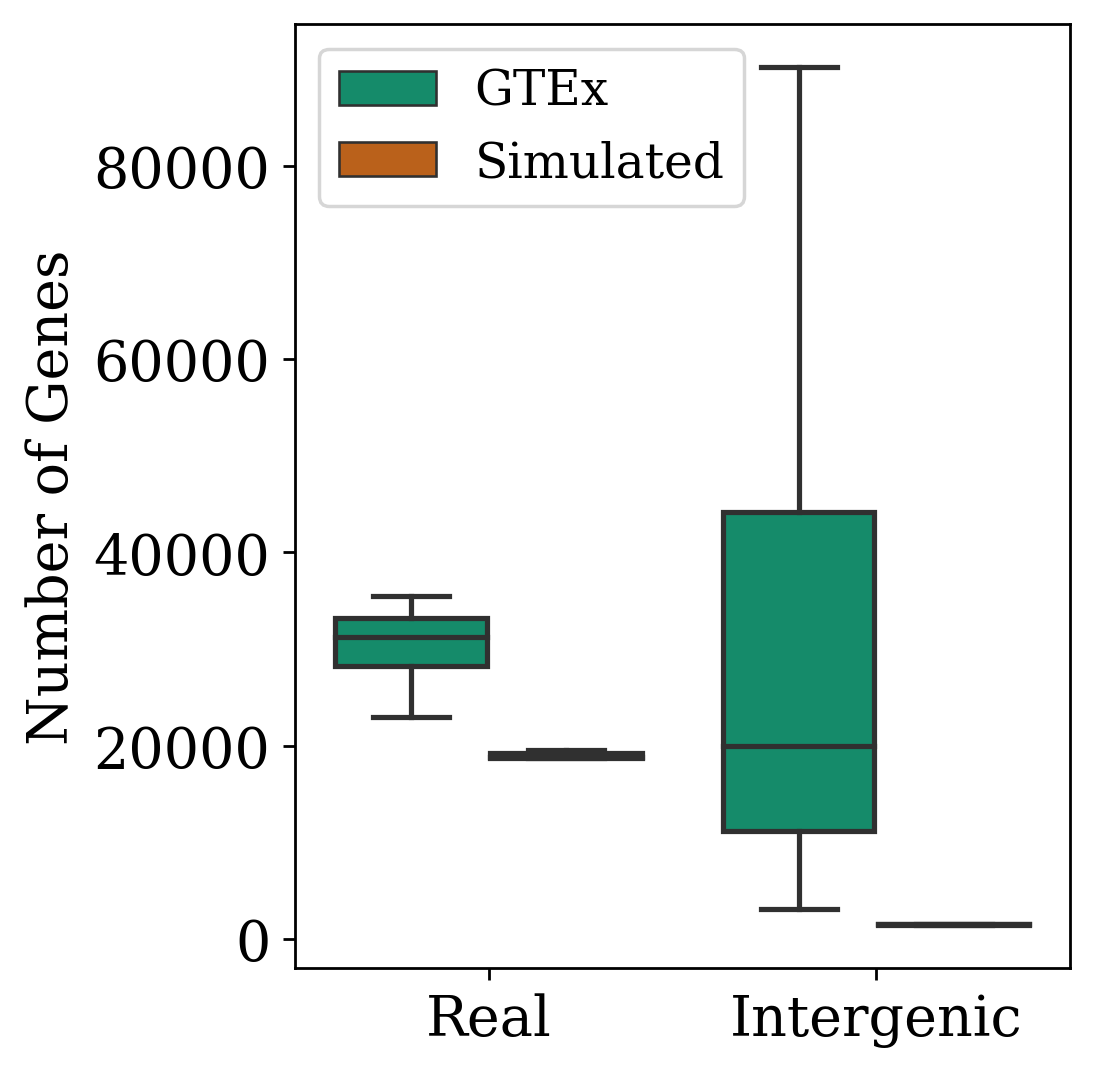

In [6]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(4,5),dpi=250)
ax = sns.boxplot(x="Gene Type",y="Number of Genes",hue="Dataset",data=res_tloc_df,palette=sns.color_palette("colorblind",4)[2:])
# ax.set_title("Number of Genes per Tissue in GTEx\nand Simulated Datasets")
ax.set_xlabel("")
ax.set_ylabel("Number of Genes")
legend = plt.legend(loc='upper left',fontsize=14)
fig.savefig(fig_dir+"num_genes_tissue.eps", format='eps')
plt.show()

In [7]:
s_loc = pd.read_csv(base_dir_out+"res.num_locs_sample")
s_loc = s_loc[["all_real","intergenic"]]
s_loc.columns = ["Real","Intergenic"]
q25,q50,q75 = s_loc['Real'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = s_loc[s_loc["Real"]<=thw]["Real"].max()
alw = s_loc[s_loc["Real"]>=tlw]["Real"].min()
s_loc = s_loc[(s_loc['Real']<=ahw)&(s_loc['Real']>=alw)]

q25,q50,q75 = s_loc['Intergenic'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = s_loc[s_loc["Intergenic"]<=thw]["Intergenic"].max()
alw = s_loc[s_loc["Intergenic"]>=tlw]["Intergenic"].min()
s_loc = s_loc[(s_loc['Intergenic']<=ahw)&(s_loc['Intergenic']>=alw)]
s_loc = pd.DataFrame(s_loc.stack()).reset_index().drop("level_0",axis=1)
s_loc.columns = ["Gene Type","Number of Genes"]
s_loc["Dataset"] = "GTEx"

num_locs_sample_sim = pd.concat([pd.DataFrame(num_locs_sample_real,columns=["Real"]),\
                                 pd.DataFrame(num_locs_sample_intergenic,columns=["Intergenic"])],axis=1)
num_locs_sample_sim = pd.DataFrame(num_locs_sample_sim.stack()).reset_index().drop("level_0",axis=1)
num_locs_sample_sim.columns = ["Gene Type","Number of Genes"]
num_locs_sample_sim["Dataset"] = "Simulated"
res_sloc_df = pd.concat([s_loc,num_locs_sample_sim],axis=0).reset_index(drop=True)
res_sloc_df

,Gene Type,Number of Genes,Dataset
0,Real,12657,GTEx
1,Intergenic,892,GTEx
2,Real,14991,GTEx
3,Intergenic,1061,GTEx
4,Real,14995,GTEx
...,...,...,...
17105,Intergenic,1201,Simulated
17106,Real,17509,Simulated
17107,Intergenic,1390,Simulated
17108,Real,15168,Simulated


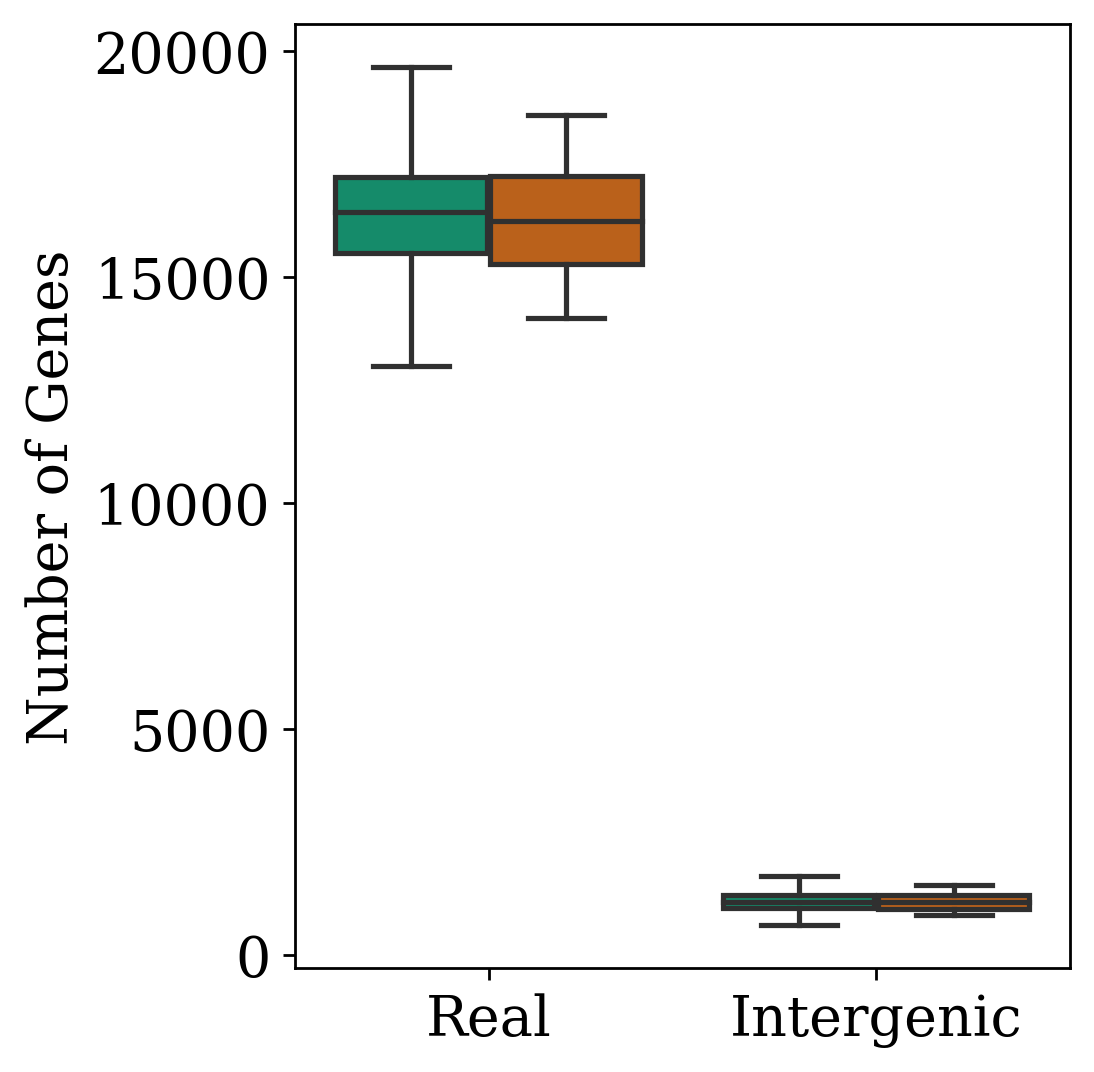

In [8]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(4,5),dpi=250)
ax = sns.boxplot(x="Gene Type",y="Number of Genes",hue="Dataset",data=res_sloc_df,palette=sns.color_palette("colorblind",4)[2:],showfliers=False)
# ax.set_title("Number of Genes per Sample in GTEx\nand Simulated Datasets")
ax.set_xlabel("")
ax.set_ylabel("Number of Genes")
ax.legend().remove()
fig.savefig(fig_dir+"num_genes_sample.eps", format='eps')
plt.show()

In [9]:
tx_ns = pd.read_csv(base_dir_out+"res.num_tx_per_sample")
tx_ns = tx_ns[["real","splicing","intronic","intergenic"]]
tx_ns.columns = ["Real","Splicing","Intronic","Intergenic"]
tx_ns = pd.DataFrame(tx_ns.stack()).reset_index().drop("level_0",axis=1)
tx_ns.columns = ["Transcript Type","Number of Transcripts"]
tx_ns["Dataset"] = "GTEx"

num_txs_sample_sim = pd.concat([pd.DataFrame(num_txs_sample_real,columns=["Real"]),\
                                pd.DataFrame(num_txs_sample_splicing,columns=["Splicing"]),\
                                pd.DataFrame(num_txs_sample_intronic,columns=["Intronic"]),\
                                pd.DataFrame(num_txs_sample_intergenic,columns=["Intergenic"])],axis=1)
num_txs_sample_sim = pd.DataFrame(num_txs_sample_sim.stack()).reset_index().drop("level_0",axis=1)
num_txs_sample_sim.columns = ["Transcript Type","Number of Transcripts"]
num_txs_sample_sim["Dataset"] = "Simulated"
res_stx_df = pd.concat([tx_ns,num_txs_sample_sim],axis=0).reset_index(drop=True)
res_stx_df

,Transcript Type,Number of Transcripts,Dataset
0,Real,34935,GTEx
1,Splicing,11466,GTEx
2,Intronic,686,GTEx
3,Intergenic,2359,GTEx
4,Real,37929,GTEx
...,...,...,...
39295,Intergenic,1406,Simulated
39296,Real,25083,Simulated
39297,Splicing,10714,Simulated
39298,Intronic,1151,Simulated


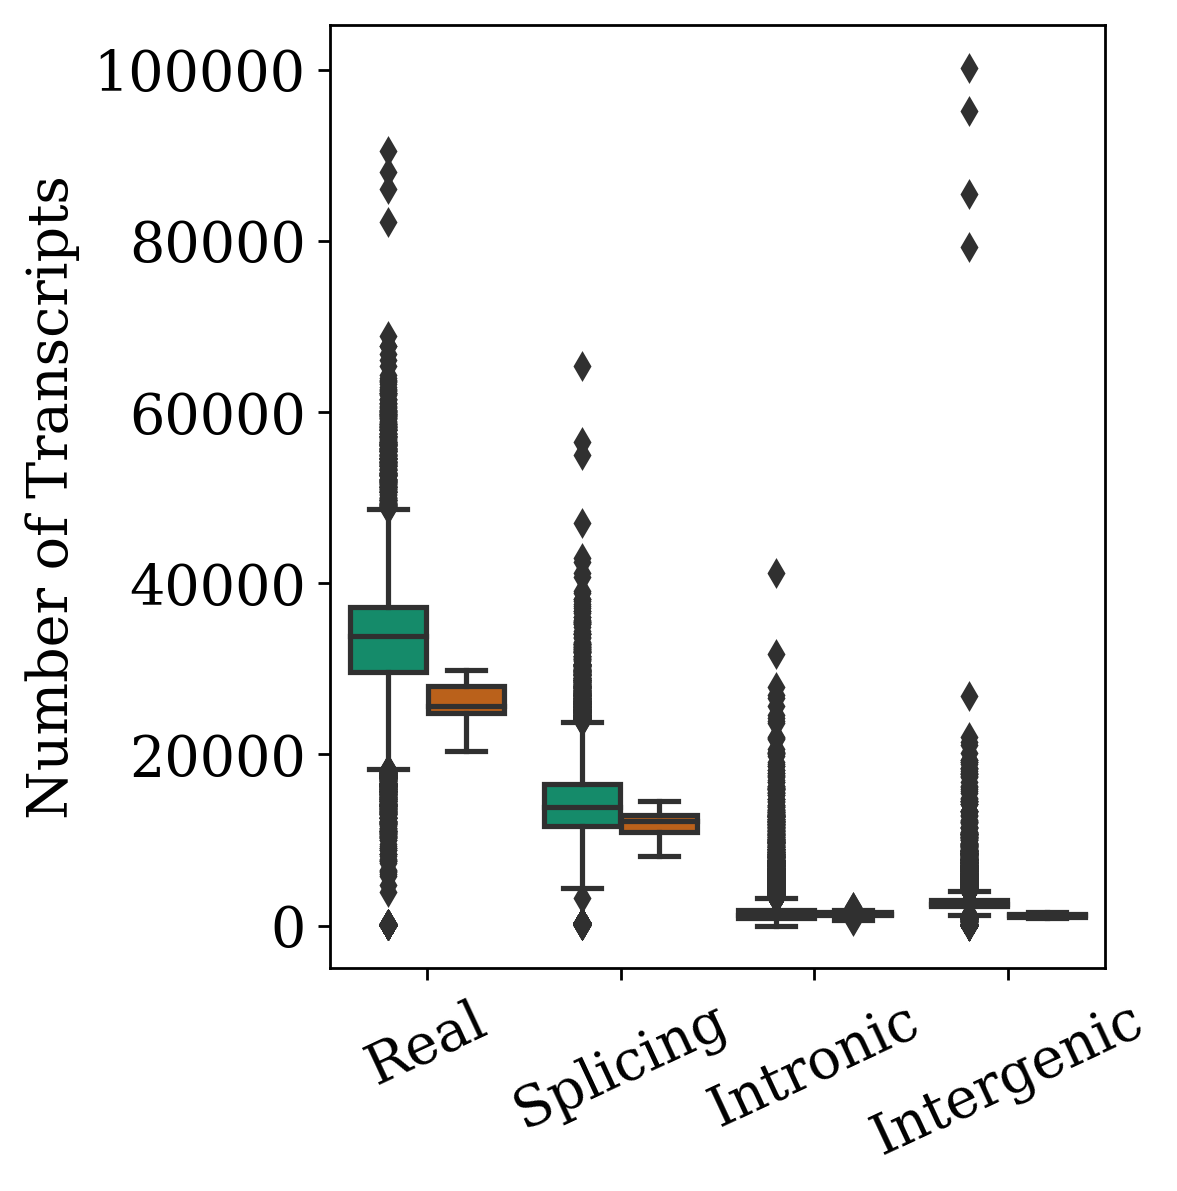

In [10]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(4,5),dpi=250)
ax = sns.boxplot(x="Transcript Type",y="Number of Transcripts",hue="Dataset",data=res_stx_df,palette=sns.color_palette("colorblind",4)[2:],showfliers=True)
# ax.set_title("Number of Transcripts per Sample in GTEx\nand Simulated Datasets")
ax.set_xlabel("")
ax.set_ylabel("Number of Transcripts")
ax.legend().remove()
plt.setp(ax.xaxis.get_majorticklabels(),rotation=25)
fig.savefig(fig_dir+"num_tx_sample.eps", format='eps')
plt.show()

In [11]:
frac_real_sample = []
frac_real_locs = []

total_real_locs = []
total_noise_locs = []

for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        sum_real = real_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_splicing = splicing_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_intronic = intronic_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_intergenic = intergenic_gtfs[tissue_num][sample_num]["tpm"].sum()
        frac_real_sample.append((sum_real/(sum_real+sum_splicing+sum_intronic+sum_intergenic))*100.0)
        
        realg = real_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        realg.columns = ["lid","tpm_real"]
        splicingg = splicing_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        splicingg.columns = ["lid","tpm_splicing"]
        intronicg = intronic_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        intronicg.columns = ["lid","tpm_intronic"]
        joined = realg.merge(splicingg,on="lid",how="outer",indicator=True)
        joined["tpm_real"] = joined["tpm_real"].fillna(0)
        joined.drop("_merge",axis=1,inplace=True)
        joined = joined.merge(intronicg,on="lid",how="outer",indicator=True)
        joined["tpm_real"] = joined["tpm_real"].fillna(0)
        joined.drop("_merge",axis=1,inplace=True)
        joined["tpm_splicing"] = joined.tpm_splicing.fillna(0)
        joined["tpm_intronic"] = joined.tpm_intronic.fillna(0)
        joined["tpm_total"] = joined.tpm_real+joined.tpm_splicing+joined.tpm_intronic
        joined["frac_tpm_real"] = joined.tpm_real/joined.tpm_total
        joined["total_tpm_noise"] = joined["tpm_splicing"]+joined["tpm_intronic"]
        
        frac_real_locs.extend(joined["frac_tpm_real"].tolist())
        total_real_locs.extend(joined["tpm_real"].tolist())
        total_noise_locs.extend(joined["total_tpm_noise"].tolist())

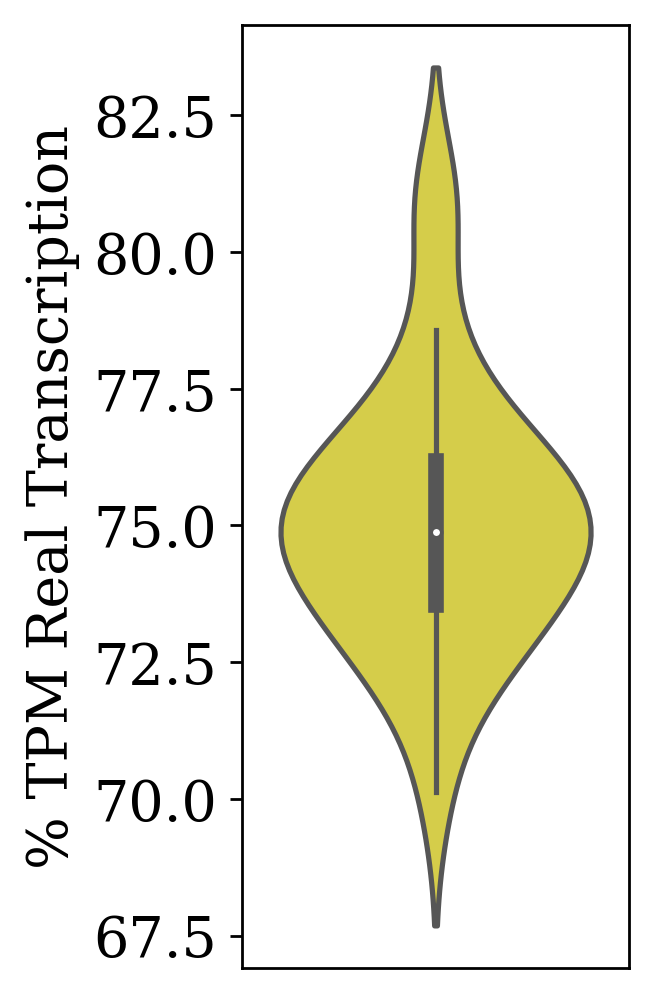

In [12]:
frac_real_sample_df = pd.DataFrame(frac_real_sample,columns=["frac_real"])
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(2,5),dpi=250)
frac_real_sample_df["blank"] = "spacer"
ax = sns.violinplot(x="blank",y="frac_real",data=frac_real_sample_df,color=sns.color_palette("colorblind")[8])
# ax.set_title("False Positive Rate in the Absence and \n Presence of Noisy Transcription")
ax.set_xlabel("")
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.set_ylabel("% TPM Real Transcription")
fig.savefig(fig_dir+"frac_real_sample.eps", format='eps')
plt.show()

In [13]:
stats_loc5 = pd.read_csv(base_dir_out+"res.num_tx_per_sample_loc5")
stats_loc5_nt = stats_loc5[["sample","real","splicing","intronic","intergenic"]]
stats_loc5 = stats_loc5[["total_tpm_real","total_tpm_splicing","total_tpm_intronic","total_tpm_intergenic"]]
stats_loc5["tpm_total"] = stats_loc5.total_tpm_real+stats_loc5.total_tpm_splicing+stats_loc5.total_tpm_intronic
stats_loc5["frac_tpm_real"] = stats_loc5.total_tpm_real/stats_loc5.tpm_total
stats_loc5["total_tpm_noise"] = stats_loc5["total_tpm_splicing"]+stats_loc5["total_tpm_intronic"]
stats_loc5.head()

,total_tpm_real,total_tpm_splicing,total_tpm_intronic,total_tpm_intergenic,tpm_total,frac_tpm_real,total_tpm_noise
0,0.00000,4.92635,0.0,0.0,4.92635,0.0,4.92635
1,2.88853,0.00000,0.0,0.0,2.88853,1.0,0.00000
2,2.61178,0.00000,0.0,0.0,2.61178,1.0,0.00000
3,0.00000,1.58056,0.0,0.0,1.58056,0.0,1.58056
4,7.63499,0.00000,0.0,0.0,7.63499,1.0,0.00000


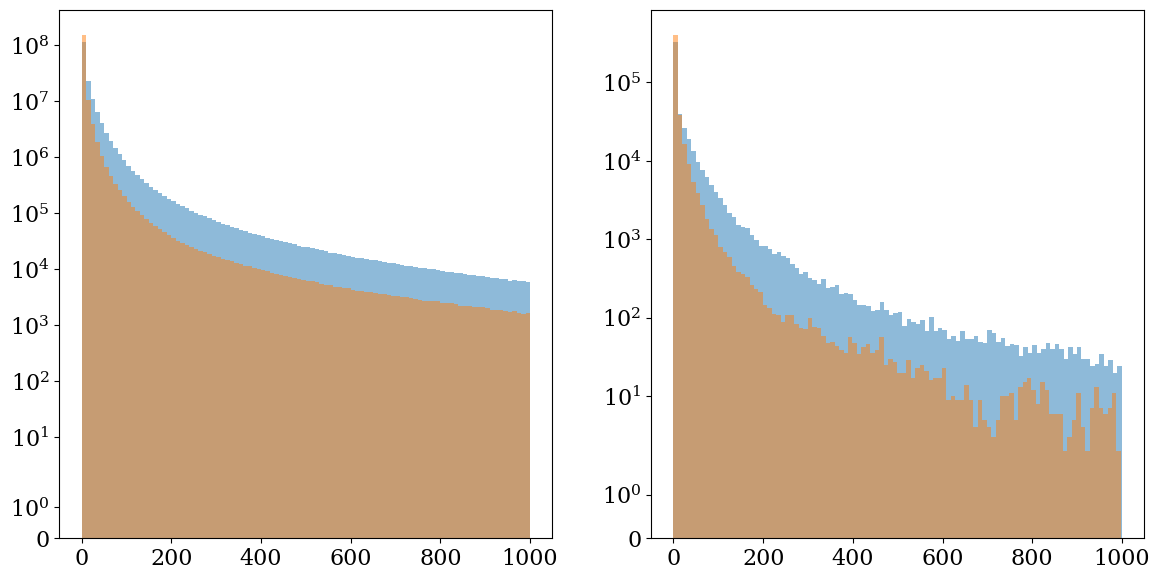

In [14]:
total_locs = pd.concat([pd.DataFrame(total_real_locs,columns=["real"]),\
                        pd.DataFrame(total_noise_locs,columns=["noise"])],axis=1)

fig1, axes = plt.subplots(ncols=2,nrows=1,figsize=(14,7),dpi=100)
axes[0].hist(stats_loc5[(stats_loc5["total_tpm_real"]<1000)]["total_tpm_real"],bins=100,alpha=0.5,label='real')
axes[0].hist(stats_loc5[(stats_loc5["total_tpm_noise"]<1000)]["total_tpm_noise"],bins=100,alpha=0.5,label='noise')
axes[0].set_yscale("symlog")

axes[1].hist(total_locs[(total_locs["real"]<1000)]["real"],bins=100,alpha=0.5,label='real')
axes[1].hist(total_locs[(total_locs["noise"]<1000)]["noise"],bins=100,alpha=0.5,label='noise')
axes[1].set_yscale("symlog")

plt.show()

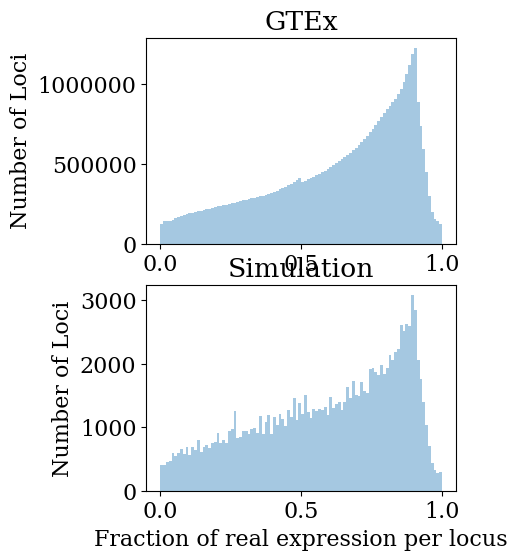

In [15]:
frac_locs = pd.DataFrame(frac_real_locs,columns=["frac_real"])

fig1, axes = plt.subplots(ncols=1,nrows=2,figsize=(4,6),dpi=100)
# axes[0].hist(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&(stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],bins=100,alpha=0.5,label='frac_real')
sns.distplot(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&\
                        (stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],bins=100,label='frac_real',kde=False,ax=axes[0]);
# axes[1].hist(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,alpha=0.5,label='frac_real')
sns.distplot(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,kde=False,ax=axes[1]);
axes[0].set_title("GTEx")
axes[0].set_ylabel("Number of Loci")
axes[0].set_xlabel("")
axes[1].set_title("Simulation")
axes[1].set_xlabel("Fraction of real expression per locus")
axes[1].set_ylabel("Number of Loci")
# plt.suptitle("Fraction of Expression\nFrom Annotated Transcripts per Gene")
plt.show()

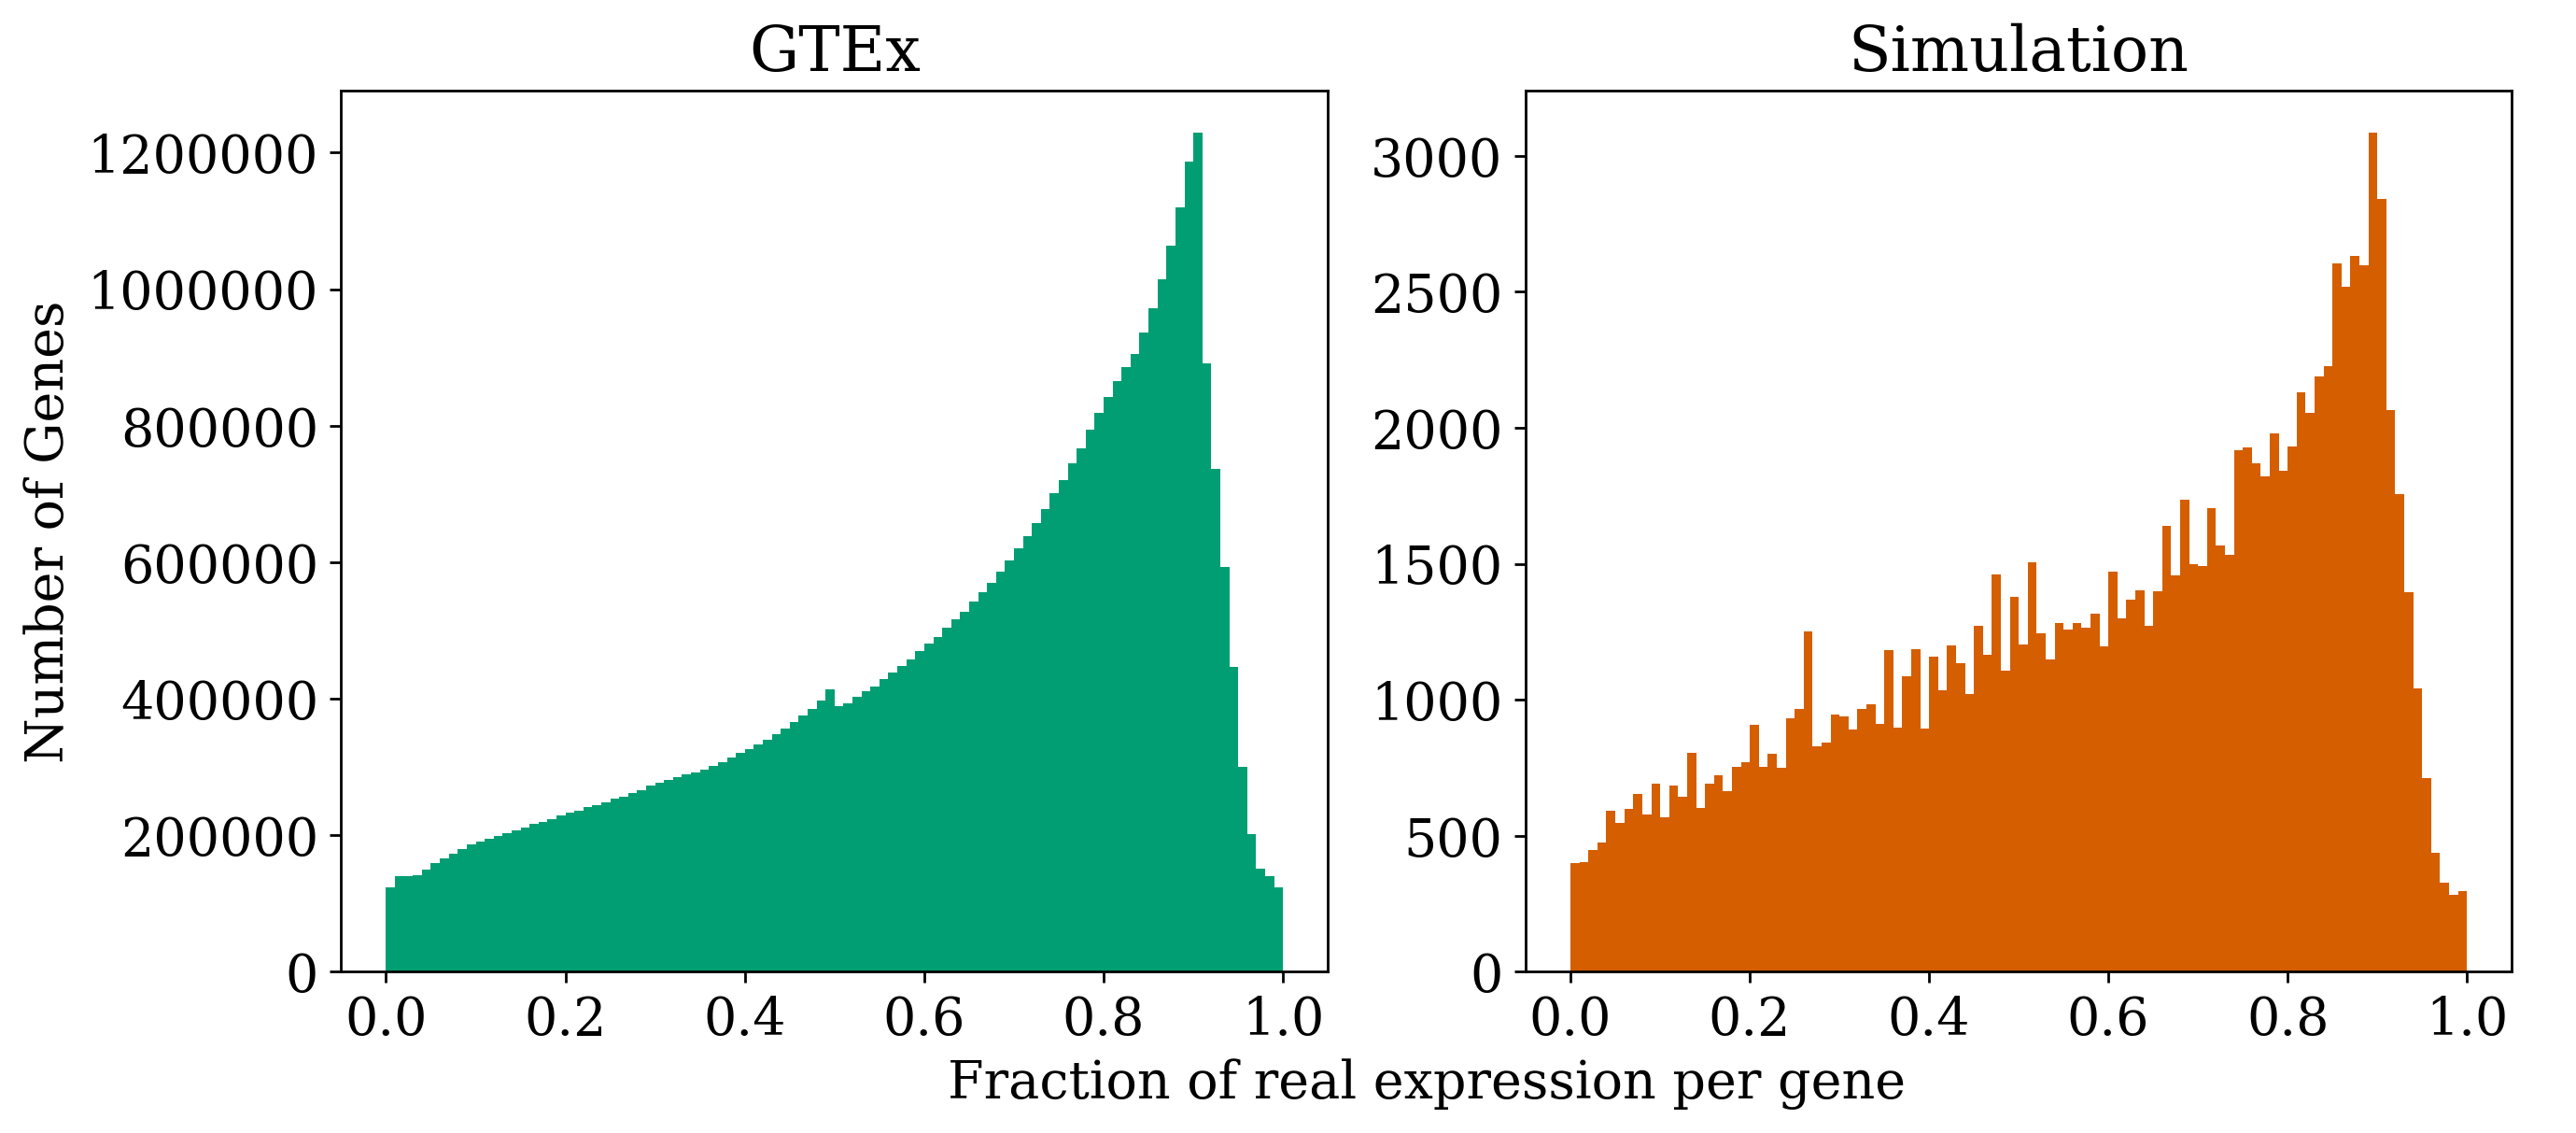

In [16]:
# frac_locs = pd.DataFrame(frac_real_locs,columns=["frac_real"])
plt.rcParams['font.size'] = 16
fig1, axes = plt.subplots(ncols=2,nrows=1,sharex=True,figsize=(12,5),dpi=250)
# axes[0].hist(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&(stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],bins=100,alpha=0.5,label='frac_real')
dist0 = sns.distplot(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&\
                        (stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],
                         bins=100,label='frac_real',
                         kde=False,
                         color=sns.color_palette("colorblind")[2],
                         hist_kws=dict(edgecolor="k", linewidth=0,alpha=1),
                         ax=axes[0]);
# axes[1].hist(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,alpha=0.5,label='frac_real')
dist1 = sns.distplot(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],
                         bins=100,
                         kde=False,
                         color=sns.color_palette("colorblind")[3],
                         hist_kws=dict(edgecolor="k", linewidth=0,alpha=1),
                         ax=axes[1]);

# for i in range(len(axes[0].artists)):
#     axes[0].artists[i].set_facecolor(sns.color_palette("colorblind",10)[8])
    
# dist0.set_fc(sns.color_palette("colorblind",10)[8])
# dist0.set_alpha(0)

axes[0].set_title("GTEx")
axes[0].set_ylabel("Number of Genes")
axes[0].set_xlabel("")
axes[1].set_title("Simulation")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
# plt.suptitle("Fraction of Expression\nFrom Annotated Transcripts per Gene")

fig1.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Fraction of real expression per gene")

fig1.savefig(fig_dir+"frac_real.eps", format='eps')
plt.show()

In [17]:
# what is the mean fraction of noise per locus
mean_tpm = stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&\
                        (stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"].mean()
median_tpm = stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&\
                        (stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"].median()
print(1-mean_tpm,1-median_tpm)

0.37082621960515705 0.3054444182269428


In [18]:
mean_tpm = frac_locs["frac_real"].mean()
median_tpm = frac_locs["frac_real"].median()
print(1-mean_tpm,1-median_tpm)

0.32532670716256296 0.0


In [19]:
# what fraction of transcripts from the total actually has
# 1. both noise and real
# 2. only noise
# 3. only real
num_both = len(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&\
                        (stats_loc5["frac_tpm_real"]>0.0)])
num_real = len(stats_loc5[stats_loc5["frac_tpm_real"]==1.0])
num_noise = len(stats_loc5[stats_loc5["frac_tpm_real"]==0.0])
num_intergenic = len(stats_loc5[stats_loc5.frac_tpm_real.isna()])
num_total = len(stats_loc5)
print((num_both/num_total)*100)
print((num_real/num_total)*100)
print((num_noise/num_total)*100)
print((num_intergenic/num_total)*100)

print(((num_both/num_total)*100)+((num_real/num_total)*100)+((num_noise/num_total)*100)+((num_intergenic/num_total)*100))

25.366405219292528
45.138429466007395
21.549285737600655
7.9458795770994195
100.0


In [20]:
# lastly, we need to look at the requency of occurence of each type of transcript in tissue
freq_df = pd.read_csv(base_dir_out+"res.tissue_tx_freq")
freq_df.head()

,type,freq
0,real,0.001610
1,real,0.186795
2,real,0.566828
3,real,0.801932
4,real,0.059581


In [21]:
freq_df_g = freq_df.groupby(by="type").mean()
freq_df_g

,freq
type,
intergenic,0.018173
intronic,0.005498
real,0.255454
splicing,0.014070
